In [161]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

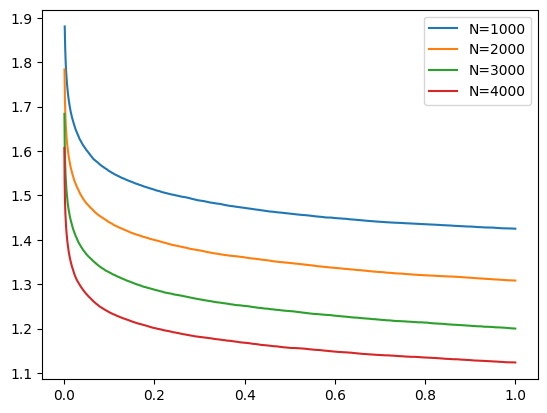

In [224]:
NS = jnp.array([1000,2000, 3000, 4000])
prefix = "FN"
for N in NS:
    paths_1 = jnp.load(f'{prefix}_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    plt.plot(ts, jnp.log(jnp.mean(jnp.linalg.norm(paths_1-paths_2, axis=-1),axis=0))/jnp.log(1/(N-1)),label=f'N={N-1}')
plt.legend()

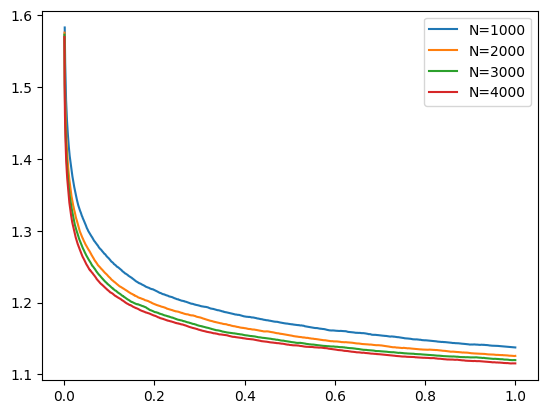

In [225]:
NS = jnp.array([1000,2000, 3000, 4000])
prefix = "FN"
for N in NS:
    paths_1 = jnp.load(f'{prefix}_onepass_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    plt.plot(ts, jnp.log(jnp.mean(jnp.linalg.norm(paths_1-paths_2, axis=-1),axis=0))/jnp.log(1/(N-1)),label=f'N={N-1}')
plt.legend()

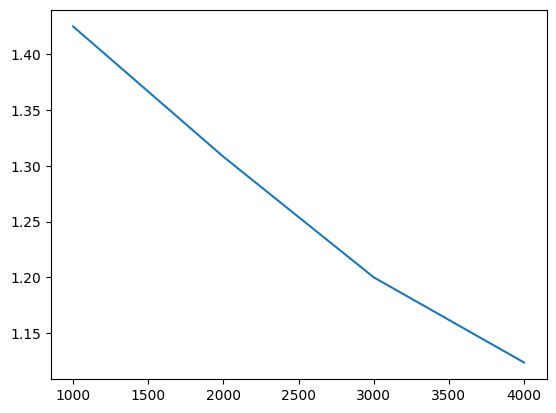

In [226]:
gammas_hat = []
for N in NS:
    paths_1 = jnp.load(f'{prefix}_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    gamma_hat = jnp.log(jnp.max(jnp.mean(jnp.linalg.norm(paths_1-paths_2, axis=-1),axis=0)))/jnp.log(1/(N-1))
    gammas_hat.append(gamma_hat)
plt.plot(NS, gammas_hat)


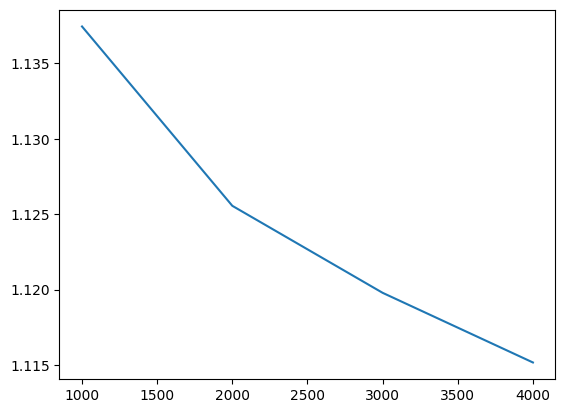

In [218]:
gammas_hat = []
for N in NS:
    paths_1 = jnp.load(f'{prefix}_onepass_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    gamma_hat = jnp.log(jnp.max(jnp.mean(jnp.linalg.norm(paths_1-paths_2, axis=-1),axis=0)))/jnp.log(1/(N-1))
    gammas_hat.append(gamma_hat)
plt.plot(NS, gammas_hat)


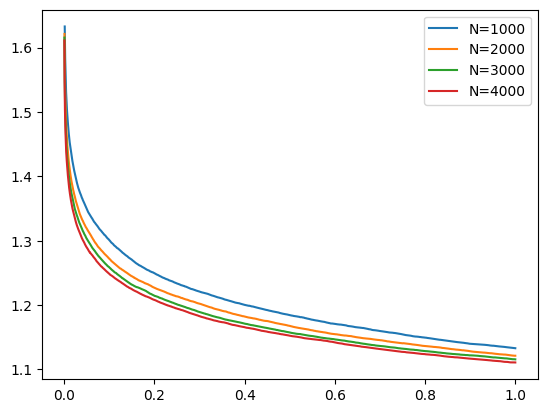

In [219]:
NS = jnp.array([1000,2000, 3000, 4000])
prefix = "IBM"
for N in NS:
    paths_1 = jnp.load(f'{prefix}_onepass_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    plt.plot(ts, jnp.log(jnp.mean(jnp.linalg.norm(paths_1-paths_2, axis=-1),axis=0))/jnp.log(1/(N-1)),label=f'N={N-1}')
plt.legend()

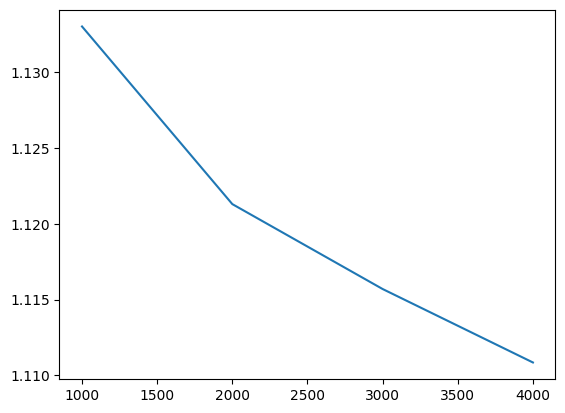

In [220]:
gammas_hat = []
for N in NS:
    paths_1 = jnp.load(f'{prefix}_onepass_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    gamma_hat = jnp.log(jnp.max(jnp.mean(jnp.linalg.norm(paths_1-paths_2, axis=-1),axis=0)))/jnp.log(1/(N-1))
    gammas_hat.append(gamma_hat)
plt.plot(NS, gammas_hat)


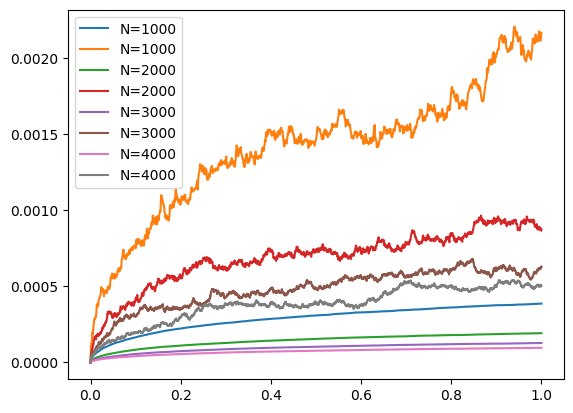

In [223]:
NS = jnp.array([1000,2000, 3000, 4000])
prefix = "FN"
for N in NS:
    paths_1 = jnp.load(f'{prefix}_onepass_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    plt.plot(ts, jnp.mean(jnp.linalg.norm(paths_1-paths_2, axis=-1), axis=0), label=f'N={N-1}')
    plt.plot(ts, jnp.max(jnp.linalg.norm(paths_1-paths_2, axis=-1), axis=0),label=f'N={N-1}')

plt.legend()

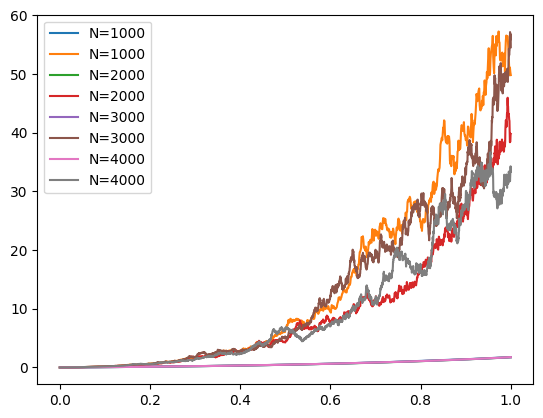

In [227]:
NS = jnp.array([1000,2000, 3000, 4000])
prefix = "GBM"
for N in NS:
    paths_1 = jnp.load(f'{prefix}_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    plt.plot(ts, jnp.mean(jnp.linalg.norm(paths_1-paths_2, axis=-1), axis=0), label=f'N={N-1}')
    plt.plot(ts, jnp.max(jnp.linalg.norm(paths_1-paths_2, axis=-1), axis=0),label=f'N={N-1}')

plt.legend()

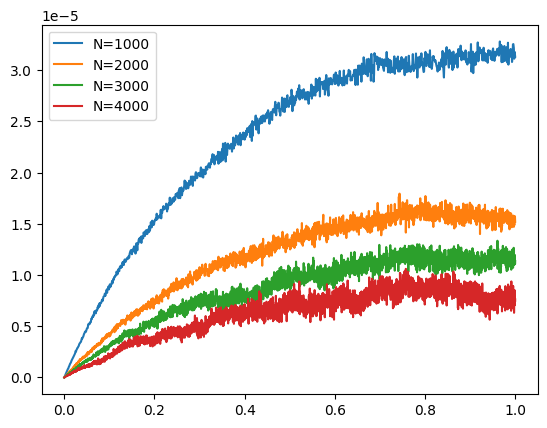

In [236]:
NS = jnp.array([1000,2000, 3000, 4000])
prefix = "FN"
for N in NS:
    paths_1 = jnp.load(f'{prefix}_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    _cov_2 = jnp.array([jnp.cov(paths_2[:,k,:], rowvar=False) for k in ranged])
    _cov_1 = jnp.array([jnp.cov(paths_1[:,k,:], rowvar=False) for k in ranged])
    dist_cov = jnp.array([jnp.linalg.norm(_cov_2[k]-_cov_1[k]) for k in ranged])
    plt.plot(ts, dist_cov, label=f'N={N-1}')
plt.legend()